<a href="https://colab.research.google.com/github/componavt/volcano_wikidata/blob/main/src/%20voleq_group_types.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌋+🌎 Group Type Analysis: Volcanoes & Earthquakes

This script analyzes clusters (connected components) of volcanoes and earthquakes based on a spatial proximity threshold (`dist_max`). We form **groups** (clusters) where the distance between any two points is below `dist_max`.

For each distance, we compute:

- 🌋 **Number of volcano-only groups** — groups containing only volcanoes.
- 🌎 **Number of earthquake-only groups** — groups containing only earthquakes.
- 🌋+🌎 **Number of mixed groups** — groups containing both volcanoes and earthquakes.

The goal is to understand the composition of spatial clusters depending on distance.

For the program to work, you need two CSV files generated using SPARQL queries: https://w.wiki/AXz7 and https://w.wiki/AY2R

In [32]:
# Input parameters
LANGUAGE = 'ru'  # 'en' or 'ru'

f_volcano = "volcanoes_2023.csv"
f_earthquake = "earthquakes_2023.csv"

# --- Distance thresholds to explore ---
# dist_max = 100  # maximum distance (km) between volcano and earthquake to draw a line

# distances_max_list = range(10, 250, 10)  # Test thresholds from 10 km to 250 km
# distances_max_list = range(30, 150, 10)
distances_max_list = list(range(30, 80, 10)) + list(range(80, 100, 1)) + list(range(100, 150, 10)) # slow real
# distances_max_list = list(range(30, 80, 20)) + list(range(80, 100, 5)) + list(range(100, 150, 20)) # fast

# шаг 10 для диапазона 80-170, но шаг 2 для диапазона 120-130, чтобы увидеть на графике локальный изгиб
# [80, 90, 100, 110, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 140, 150, 160]
#distances_max_list = list(range(80, 120, 10)) + list(range(120, 130, 1)) + list(range(130, 170, 10))

# fast: шаг 40 для диапазона 80-170, но шаг 5 для диапазона 120-130, чтобы увидеть на графике локальный изгиб
# [80, 120, 127, 128, 130, 170]
#distances_max_list = list(range(80, 121, 40)) + [125] + list(range(127, 129, 1)) + list(range(130, 171, 40))
#distances_max_list = list(range(80, 121, 40))          + list(range(127, 129, 1)) + list(range(130, 171, 40))

print(distances_max_list)

[30, 40, 50, 60, 70, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 110, 120, 130, 140]


In [33]:
import csv
import numpy as np
from geopy.distance import geodesic
from scipy.spatial import KDTree
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import folium
# import pprint # Pretty Print for objects


# Download CSV files from GitHub
!wget https://raw.githubusercontent.com/componavt/volcano_wikidata/master/data/$f_volcano
!wget https://raw.githubusercontent.com/componavt/volcano_wikidata/master/data/$f_earthquake

!head -n 3 $f_volcano
!head -n 3 $f_earthquake

--2025-05-04 10:01:41--  https://raw.githubusercontent.com/componavt/volcano_wikidata/master/data/volcanoes_2023.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 76165 (74K) [text/plain]
Saving to: ‘volcanoes_2023.csv.5’

volcanoes_2023.csv. 100%[===================>]  74.38K  --.-KB/s    in 0.02s   

2025-05-04 10:01:41 (3.39 MB/s) - ‘volcanoes_2023.csv.5’ saved [76165/76165]

--2025-05-04 10:01:41--  https://raw.githubusercontent.com/componavt/volcano_wikidata/master/data/earthquakes_2023.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 

# 📏 Computing the Maximum Diameter of a Group

In [34]:
from geopy.distance import geodesic

def compute_group_diameter(group_coords):
    max_distance = 0
    n = len(group_coords)
    for i in range(n):
        for j in range(i+1, n):
            d = geodesic(group_coords[i], group_coords[j]).km
            if d > max_distance:
                max_distance = d
    return max_distance

# 📉 Compresses scale before 120, 📈 stretches 120-130, 📉 compresses after 130.

In [35]:
def transform_x(x, compress_before=0.5, compress_between=2.0, compress_after=0.5):
    """
    Transforms the input distance x with different compression ratios for different intervals.

    Parameters:
        x (float): Input distance value to be transformed
        compress_before (float): Compression factor for x < 120 (default: 0.5)
        compress_between (float): Compression/stretch factor for 120 <= x <= 130 (default: 2.0)
        compress_after (float): Compression factor for x > 130 (default: 0.5)

    Returns:
        float: Transformed value of x according to the specified compression rules

    Behavior:
        - For x < 120: applies compress_before multiplier (compression if < 1.0)
        - For 120-130: applies compress_between multiplier (stretches if > 1.0)
        - For x > 130: applies compress_after multiplier (compression if < 1.0)
    """
    if x < 120:
        return x * compress_before  # Compress region before 120 km
    elif 120 <= x <= 130:
        return 120 * compress_before + (x - 120) * compress_between  # Transform 120-130 km region
    else:
        return (120 * compress_before + 10 * compress_between) + (x - 130) * compress_after  # Compress region after 130 km

# 📊 Volcano–Earthquake Grouping Analysis with Distance Thresholds 🌋🌎

This script analyzes how volcanoes and earthquakes cluster together depending on the maximum allowed distance (`dist_max`) between points.

**Key steps:**
- A KD-tree is built to efficiently find neighbors within `dist_max`.
- Groups (connected components) are extracted at each threshold.
- Several metrics are calculated and plotted:
  - Number of Groups
  - Average Group Size
  - Group Size Variance
  - Largest Group Size
- Specific points of interest (distances 127–128 km) are highlighted.
- A detailed zoom into the critical range (120–130 km) is visually marked.

✨ The analysis helps detect natural clusterings and transition zones between fragmented and merged structures.

---

# 📊 Анализ группировки вулканов и землетрясений в зависимости от порога расстояния 🌋🌎

Этот скрипт исследует, как вулканы и землетрясения группируются в зависимости от максимально допустимого расстояния (`dist_max`) между точками.

**Основные шаги:**
- Строится KD-дерево для эффективного поиска соседей на заданном расстоянии.
- При каждом значении `dist_max` выделяются группы (связные компоненты).
- Вычисляются и строятся графики для следующих метрик:
  - Число групп
  - Средний размер группы
  - Дисперсия размеров групп
  - Размер крупнейшей группы
- Особо выделены точки при расстояниях 127–128 км.
- На графике отмечен диапазон детального рассмотрения (120–130 км).

✨ Анализ помогает обнаружить естественные кластеры и переходные зоны между разрозненными и объединёнными структурами.

dist_max=30 km: 2127 groups, only volcano: 636, only earthquakes: 1420, mixed: 71, avg size 1.72, largest group 65, largest diameter 161.05 km, % mixed: 3.3%
dist_max=40 km: 1868 groups, only volcano: 526, only earthquakes: 1254, mixed: 88, avg size 1.96, largest group 66, largest diameter 304.15 km, % mixed: 4.7%
dist_max=50 km: 1625 groups, only volcano: 432, only earthquakes: 1097, mixed: 96, avg size 2.25, largest group 93, largest diameter 432.42 km, % mixed: 5.9%
dist_max=60 km: 1434 groups, only volcano: 366, only earthquakes: 969, mixed: 99, avg size 2.55, largest group 96, largest diameter 617.22 km, % mixed: 6.9%
dist_max=70 km: 1272 groups, only volcano: 317, only earthquakes: 857, mixed: 98, avg size 2.87, largest group 96, largest diameter 660.25 km, % mixed: 7.7%
dist_max=80 km: 1148 groups, only volcano: 277, only earthquakes: 773, mixed: 98, avg size 3.18, largest group 191, largest diameter 945.06 km, % mixed: 8.5%
dist_max=81 km: 1131 groups, only volcano: 270, only e

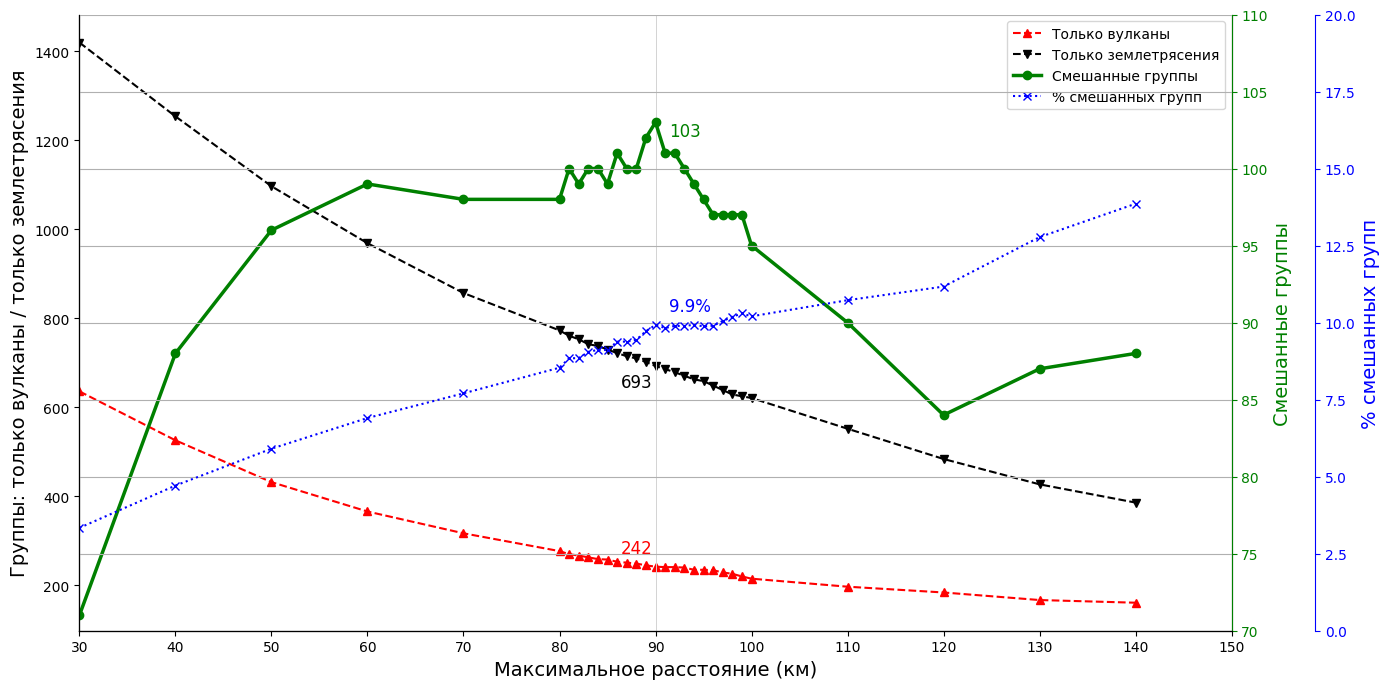

In [36]:
# --- Language translation: 'en' or 'ru' ---
def tr(en_text: str, ru_text: str) -> str:
    """Simple translator function. Returns text based on current LANGUAGE setting."""
    return ru_text if LANGUAGE == 'ru' else en_text

# --- Load volcano and earthquake coordinates ---

# Function to parse coordinate strings
# Helper to process "Point(lon lat)" format to (lat, lon)
def parse_coords(coord_string):
    lon, lat = map(float, coord_string.replace("Point(", "").replace(")", "").split())
    return (lat, lon)

volcano_coords = []
earthquake_coords = []

# Read volcanoes
with open("volcanoes_2023.csv", encoding='utf-8', newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    for row in reader:
        coord = parse_coords(row['location'])
        volcano_coords.append(coord)

# Read earthquakes
with open("earthquakes_2023.csv", encoding='utf-8', newline='') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    for row in reader:
        coord = parse_coords(row['location'])
        earthquake_coords.append(coord)

# --- Combine volcano and earthquake coordinates ---
all_coords = volcano_coords + earthquake_coords
types = ['volcano'] * len(volcano_coords) + ['earthquake'] * len(earthquake_coords)

# --- Build KD-Tree for efficient neighbor search ---
tree = KDTree(np.radians(all_coords))  # Use radians for geodesic approximation

# --- Storage for metrics ---
groups_count_list = []
average_group_size_list = []
largest_group_size_list = []
largest_group_diameter_list = []

volcano_only_list = []
earthquake_only_list = []
mixed_group_list = []

volcano_only_counts = []
earthquake_only_counts = []
mixed_group_counts = []
mixed_group_percent_list = []

def haversine_distances(coords):
    """Approximate distances matrix on the sphere."""
    from sklearn.metrics.pairwise import haversine_distances
    return haversine_distances(np.radians(coords)) * 6371.0  # Radius of Earth

# --- Compute metrics for each distance ---
for dist_max in distances_max_list:
    G = nx.Graph()

    for idx, coord in enumerate(all_coords):
        G.add_node(idx, pos=coord, type=types[idx])

    # Find neighbors within dist_max for each point
    for idx, coord in enumerate(all_coords):
        indices = tree.query_ball_point(np.radians(coord), r=dist_max/6371.0)  # r must be in radians
        for neighbor_idx in indices:
            if neighbor_idx != idx:
                G.add_edge(idx, neighbor_idx)

    # Find connected components (groups)
    connected_components = list(nx.connected_components(G))
    groups_count_list.append(len(connected_components))    # число кластеров, где точки ближе друг к другу, чем dist_max

    # Compute group size metrics
    group_sizes = [len(group) for group in connected_components]
    average_group_size_list.append(np.mean(group_sizes) if group_sizes else 0)
    largest_group_size_list.append(np.max(group_sizes) if group_sizes else 0)

    # Compute diameter metrics
    group_diameters = []
    for group in connected_components:
        coords = [all_coords[idx] for idx in group]
        diameter = compute_group_diameter(coords)
        group_diameters.append(diameter)
    # group_diameters = [compute_group_diameter([all_coords[idx] for idx in group]) for group in connected_components]

    largest_group_diameter_list.append(np.max(group_diameters) if group_diameters else 0)


    # Classify each group
    v_only, e_only, both = 0, 0, 0
    for group in connected_components:
        group_types = {types[i] for i in group}
        if group_types == {'volcano'}:
            v_only += 1
        elif group_types == {'earthquake'}:
            e_only += 1
        else:
            both += 1

    volcano_only_list.append(v_only)
    earthquake_only_list.append(e_only)
    mixed_group_list.append(both)

    total_groups = v_only + e_only + both
    percent_mixed = (both / total_groups * 100) if total_groups > 0 else 0
    mixed_group_percent_list.append(percent_mixed)

    #print(f"dist_max={dist_max} km: volcano-only={v_only}, earthquake-only={e_only}, mixed={both}")
    print(f"dist_max={dist_max} km: {len(connected_components)} groups, "
      f"only volcano: {v_only}, only earthquakes: {e_only}, mixed: {both}, "
      f"avg size {np.mean(group_sizes):.2f}, "
      f"largest group {np.max(group_sizes)}, largest diameter {np.max(group_diameters):.2f} km, "
      f"% mixed: {percent_mixed:.1f}%")

# === PLOT ONLY THE NEW FOUR CURVES ===

fig, host = plt.subplots(figsize=(14, 7))
par2 = host.twinx()
par3 = host.twinx()

# Offset third y-axis
par3.spines['right'].set_position(('outward', 60))

# Main plots
p1, = host.plot(distances_max_list, volcano_only_list, linestyle='--', marker='^', label=tr('Volcano-only Groups', 'Только вулканы'), color='red')
p2, = host.plot(distances_max_list, earthquake_only_list, linestyle='dashed', marker='v', label=tr('Earthquake-only Groups', 'Только землетрясения'), color='black')
p3, = par2.plot(distances_max_list, mixed_group_list, linestyle='-', marker='o', label=tr('Mixed Groups', 'Смешанные группы'), color='green', linewidth=2.5)
p4, = par3.plot(distances_max_list, mixed_group_percent_list, linestyle=':', marker='x', label=tr('% Mixed Groups', '% смешанных групп'), color='blue')

# Labels and titles
host.set_xlabel(tr("Maximum Distance (km)", "Максимальное расстояние (км)"), fontsize=14)
host.set_ylabel(tr("Volcano / Earthquake-only Groups", "Группы: только вулканы / только землетрясения"), fontsize=14, color='black')

# Green axis styling
par2.set_ylabel(tr("Mixed Groups", "Смешанные группы"), fontsize=14, color='green')
par3.set_ylabel(tr("% Mixed Groups", "% смешанных групп"), fontsize=14, color='blue')

# Axis styling
host.spines['top'].set_visible(False)
par2.spines['top'].set_visible(False)
par3.spines['top'].set_visible(False)

par2.tick_params(axis='y', colors='green')
par2.spines['right'].set_color('green')
par2.set_ylim(70, 110)

par3.tick_params(axis='y', colors='blue')
par3.spines['right'].set_color('blue')
par3.set_ylim(0, 20)

# Set X axis limits
host.set_xlim(30, 150)

# Add tick and vertical line at x=90
xticks = range(30, 151, 10)
host.set_xticks(xticks)
host.axvline(x=90, color='lightgrey', linestyle='-', linewidth=0.7)

# Annotate values at dist_max = 90
index_90 = distances_max_list.index(90)
host.annotate(f"{volcano_only_list[index_90]}", xy=(90, volcano_only_list[index_90]),
              xytext=(-25, 10), textcoords='offset points', fontsize=12, color='red')
host.annotate(f"{earthquake_only_list[index_90]}", xy=(90, earthquake_only_list[index_90]),
              xytext=(-25, -15), textcoords='offset points', fontsize=12, color='black')
par2.annotate(f"{mixed_group_list[index_90]}", xy=(90, mixed_group_list[index_90]),
              xytext=(10, -10), textcoords='offset points', fontsize=12, color='green')
par3.annotate(f"{mixed_group_percent_list[index_90]:.1f}%", xy=(90, mixed_group_percent_list[index_90]),
              xytext=(10, 10), textcoords='offset points', fontsize=12, color='blue')

# Combine legends
lines = [p1, p2, p3, p4]
labels = [line.get_label() for line in lines]
host.legend(lines, labels, loc='upper right')

#plt.title(tr("Group Type Breakdown by Distance", "Типы групп в зависимости от расстояния"), fontsize=16)
#plt.grid(True)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("group_type_breakdown.png", dpi=300, transparent=True)
plt.show()

🌍 Cluster Visualization on the Map (dist_max = 90 km)

This code visualizes the spatial clustering of volcanoes and earthquakes using a distance threshold of 90 km.
Each cluster is drawn as a circle whose radius covers all its points (computed by the most distant pair).
We distinguish three cluster types:

    🔴 Volcano-only clusters: red circles

    ⚫ Earthquake-only clusters: black circles

    🟢 Mixed clusters (both volcanoes and earthquakes): green dashed circles

The cluster center is calculated using the midpoint between the two most distant points in the group, ensuring the circle encloses the entire cluster.

This visualization provides geographic insight into the structure and composition of natural hazard clusters across the globe.

In [37]:
# === VISUALIZE CLUSTERS ON MAP FOR dist_max = 90 ===

# Build graph for dist_max = 90
G90 = nx.Graph()
for idx, coord in enumerate(all_coords):
    G90.add_node(idx, pos=coord, type=types[idx])
    indices = tree.query_ball_point(np.radians(coord), r=90/6371.0)
    for neighbor_idx in indices:
        if neighbor_idx != idx:
            G90.add_edge(idx, neighbor_idx)

# Find connected components
components_90 = list(nx.connected_components(G90))

# Create map centered around mean location
center_latlon = compute_center(all_coords)
m = folium.Map(location=center_latlon, zoom_start=2)

# Loop through each group and classify
for group in components_90:
    coords = [all_coords[idx] for idx in group]
    group_types = {types[idx] for idx in group}
    color = "blue"
    fill = False
    dash = False

    if group_types == {"volcano"}:
        color = "red"
        dash = False
    elif group_types == {"earthquake"}:
        color = "black"
        dash = False
    else:
        color = "green"
        dash = True

    center = compute_center_by_farthest_pair(coords)
    diameter = compute_group_diameter(coords)

    folium.Circle(
        location=center,
        radius=(diameter / 2) * 1000,
        color=color,
        fill=fill,
        dash_array="5,5" if dash else None,
        weight=2,
        opacity=0.6
    ).add_to(m)

# Show the map
m

NameError: name 'compute_center' is not defined

In [ ]:
# Анализ объединения групп при dist_max=127 и dist_max=128
# Analyzing group merging at dist_max=127 and dist_max=128

import networkx as nx
import numpy as np
from scipy.spatial import KDTree

# Search parameters
dist_min = 127
dist_max = 128

# Using pre-defined volcano_coords and earthquake_coords
all_coords = volcano_coords + earthquake_coords
types = ['volcano'] * len(volcano_coords) + ['earthquake'] * len(earthquake_coords)

# Building KD-tree for neighbor search
tree = KDTree(np.radians(all_coords))

# Function to build graph with given distance threshold
def build_graph(coords, dist_threshold_km):
    G = nx.Graph()
    for idx, coord in enumerate(coords):
        G.add_node(idx, pos=coord, type=types[idx])
        neighbors = tree.query_ball_point(np.radians(coord), r=dist_threshold_km/6371.0)
        for neighbor in neighbors:
            if neighbor != idx:
                G.add_edge(idx, neighbor)
    return G

# Build graphs for dist_max=127 and 128
G_127 = build_graph(all_coords, dist_min)
G_128 = build_graph(all_coords, dist_max)

# Get connected components (group lists)
groups_127 = list(nx.connected_components(G_127))
groups_128 = list(nx.connected_components(G_128))

print(f"Number of groups at {dist_min} km: {len(groups_127)}")
print(f"Number of groups at {dist_max} km: {len(groups_128)}")

# Create mapping: which group at 128km each point belongs to
node_to_group_128 = {}
for idx, group in enumerate(groups_128):
    for node in group:
        node_to_group_128[node] = idx

# Analyze groups at 127 km
# Check how many different 127km groups fall into the same 128km group

merged_groups = []

for group in groups_127:
    parent_groups = set(node_to_group_128[node] for node in group)
    if len(parent_groups) > 1:
        continue
    parent_group = next(iter(parent_groups))
    if len([g for g in groups_127 if any(node_to_group_128[n] == parent_group for n in g)]) > 1:
        merged_groups.append(group)

print(f"Number of merged groups: {len(merged_groups)}")

# Print group sizes
print("\nMerged Groups (sorted by size):")
merged_groups_sorted = sorted(merged_groups, key=lambda g: -len(g))
for i, g in enumerate(merged_groups_sorted):
    volcanoes = sum(1 for n in g if types[n] == 'volcano')
    earthquakes = sum(1 for n in g if types[n] == 'earthquake')
    print(f"Group {i+1}: Size = {len(g)} (Volcanoes: {volcanoes}, Earthquakes: {earthquakes})")

# Save found groups for future visualization
merged_groups_for_viz = merged_groups_sorted

# 📍 Computing the Center Based on the Farthest Pair

The function `compute_center_by_farthest_pair(group_coords)` finds the two most distant points in a group and calculates the geographic midpoint between them.

**Main idea:**
- Iterate through all point pairs to find the maximum geodesic distance.
- Take the midpoint between the two farthest points.
- Use this midpoint as a more accurate center for drawing coverage circles.

✨ This method ensures that at least the most distant points are well-centered inside the circle.

---

# 📍 Вычисление центра на основе самой удалённой пары точек

Функция `compute_center_by_farthest_pair(group_coords)` находит две наиболее удалённые точки в группе и вычисляет географический центр между ними.

**Основная идея:**
- Перебрать все пары точек и найти пару с максимальным геодезическим расстоянием.
- Вычислить середину между двумя самыми удалёнными точками.
- Использовать эту середину как более точный центр для построения круга охвата.

✨ Этот метод гарантирует, что хотя бы самые удалённые точки окажутся внутри построенного круга.

In [ ]:
def compute_center_by_farthest_pair(group_coords):
    max_distance = 0
    farthest_pair = (0, 0)
    n = len(group_coords)
    for i in range(n):
        for j in range(i+1, n):
            d = geodesic(group_coords[i], group_coords[j]).km
            if d > max_distance:
                max_distance = d
                farthest_pair = (i, j)
    # Midpoint between two farthest points
    lat1, lon1 = group_coords[farthest_pair[0]]
    lat2, lon2 = group_coords[farthest_pair[1]]
    center_lat = (lat1 + lat2) / 2
    center_lon = (lon1 + lon2) / 2
    return (center_lat, center_lon)


# Helper to compute center of a group (average coordinates)
def compute_center(coords):
    latitudes = [c[0] for c in coords]
    longitudes = [c[1] for c in coords]
    return np.mean(latitudes), np.mean(longitudes)

# 📜 Жадное покрытие группы кругами с максимальным охватом (Greedy Covering with Maximum Coverage) 🗺️

## 🇷🇺 Описание на русском:

Функция `draw_cover_circles_greedy` реализует улучшенный жадный алгоритм покрытия группы кругами:

**Основная идея:**
- На каждом шаге выбирается та вершина, которая покрывает наибольшее количество ещё непокрытых вершин.
- Строится окружность радиусом `dist_max` вокруг этой вершины.
- Все попавшие в окружность вершины удаляются из рассмотрения.
- Процесс повторяется, пока все вершины не будут покрыты.

✨ Это минимизирует общее число кругов и позволяет сохранить карту более чистой и понятной.

---

## 🇬🇧 Description in English:

The function `draw_cover_circles_greedy` implements an improved greedy algorithm for group covering with circles:

**Main idea:**
- At each step, select the node that covers the maximum number of uncovered points.
- Draw a circle with radius `dist_max` around the selected node.
- Remove all points inside the circle from the list.
- Repeat until all nodes are covered.

✨ This minimizes the total number of circles and keeps the map clean and readable.

In [ ]:
# Greedy covering: select the most effective center at each step
from geopy.distance import geodesic

def draw_cover_circles_greedy_effective(group_nodes, group_coords, color, dist_max_km, map_obj, dashed=False):
    remaining_nodes = set(range(len(group_nodes)))
    used_nodes = set()
    dist_threshold = dist_max_km  # maximum allowed distance (radius)

    while remaining_nodes:
        best_idx = None
        best_coverage = set()

        for idx in remaining_nodes:
            center_coord = group_coords[idx]
            covered = set()
            for j in remaining_nodes:
                if idx != j:
                    d = geodesic(center_coord, group_coords[j]).km
                    if d <= dist_threshold:
                        covered.add(j)
            # Always include the center itself
            covered.add(idx)

            if len(covered) > len(best_coverage):
                best_idx = idx
                best_coverage = covered

        # Draw the circle around the best node
        center_coord = group_coords[best_idx]
        folium.Circle(
            location=center_coord,
            radius=dist_max_km * 1000,  # meters
            color=color,
            fill=False,
            weight=2,
            opacity=0.7,
            dash_array="5,5" if dashed else None
        ).add_to(map_obj)

        # Remove covered nodes from the set
        remaining_nodes -= best_coverage
        used_nodes.add(best_idx)

# 🗺️ **Map of Merged Volcano and Earthquake Groups** 🌋⚡

This map shows two largest groups that merged when the distance threshold changed from 127 km to 128 km:
- 🔴 Red dots: Volcanoes
- ⚫ Black dots: Earthquakes

# 📜 Visualization of Volcano-Earthquake Groups with MST 🌋🌎

This cell visualizes the two largest merged groups using Minimum Spanning Trees (MST).  
Main features:
- Volcanoes and earthquakes are shown with different colors and shapes.
- MST edges are colored differently for Group 1 and Group 2.
- Solid lines for Group 1, dashed lines for Group 2 for better black-and-white printing.
- Thicker edges connect volcanoes and earthquakes.
- A coverage circle of 127 km radius is drawn around each group.
- Smaller and semi-transparent points are used to reduce clutter.

✨ An interactive legend explains the colors, symbols, and lines.

In [ ]:
import folium
import numpy as np
import networkx as nx
from geopy.distance import geodesic

# Select two largest groups
group1 = list(merged_groups_for_viz[0])
group2 = list(merged_groups_for_viz[1])

# Helper function to build MST for a group
def build_mst(group_nodes):
    coords = [all_coords[idx] for idx in group_nodes]
    G = nx.Graph()
    for i in range(len(coords)):
        for j in range(i+1, len(coords)):
            dist = geodesic(coords[i], coords[j]).km
            G.add_edge(i, j, weight=dist)
    mst = nx.minimum_spanning_tree(G)
    return mst, coords

# Build MSTs
mst1, coords1 = build_mst(group1)
mst2, coords2 = build_mst(group2)

center1 = compute_center(coords1)
center2 = compute_center(coords2)

# Create the map
m = folium.Map(location=center1, zoom_start=3)

# Draw MST for Group 1
for edge in mst1.edges():
    idx1, idx2 = edge
    coord1 = coords1[idx1]
    coord2 = coords1[idx2]
    node1 = group1[idx1]
    node2 = group1[idx2]
    is_mixed = (types[node1] != types[node2])
    folium.PolyLine(
        locations=[coord1, coord2],
        color="purple",
        weight=4 if is_mixed else 2,
        opacity=1,
        dash_array=None
    ).add_to(m)

# Draw MST for Group 2
for edge in mst2.edges():
    idx1, idx2 = edge
    coord1 = coords2[idx1]
    coord2 = coords2[idx2]
    node1 = group2[idx1]
    node2 = group2[idx2]
    is_mixed = (types[node1] != types[node2])
    folium.PolyLine(
        locations=[coord1, coord2],
        color="green",
        weight=4 if is_mixed else 2,
        opacity=1,
        dash_array="5,5"
    ).add_to(m)

# Draw points for Group 1
degree_count1 = dict(mst1.degree())
for idx, coord in enumerate(coords1):
    node = group1[idx]
  # size = 4 if degree_count1[idx] == 1 else 7
    size = 1 if degree_count1[idx] == 1 else 3
    color = "red" if types[node] == "volcano" else "black"
    folium.CircleMarker(
        location=coord,
        radius=size,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6
    ).add_to(m)

# Draw points for Group 2
degree_count2 = dict(mst2.degree())
for idx, coord in enumerate(coords2):
    node = group2[idx]
#   size = 4 if degree_count2[idx] == 1 else 7
    size = 1 if degree_count1[idx] == 1 else 3
    color = "#FFA07A" if types[node] == "volcano" else "#2F4F4F"
    folium.RegularPolygonMarker(
        location=coord,
        number_of_sides=5 if types[node] == "volcano" else 4,
        radius=size,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6
    ).add_to(m)


# Compute diameters
diameter1 = compute_group_diameter(coords1)
diameter2 = compute_group_diameter(coords2)

print(f"Diameter of Group 1: {diameter1:.2f} km")
print(f"Diameter of Group 2: {diameter2:.2f} km")



# Compute better centers for Group 1 and Group 2
center1_better = compute_center_by_farthest_pair(coords1)
center2_better = compute_center_by_farthest_pair(coords2)

# Draw big circles with improved centers
folium.Circle(
    location=center1_better,
    radius=(diameter1 / 2) * 1000,  # meters
    color="purple",
    fill=False,
    weight=3,
    opacity=0.5
).add_to(m)

folium.Circle(
    location=center2_better,
    radius=(diameter2 / 2) * 1000,
    color="green",
    fill=False,
    dash_array="5,5",
    weight=3,
    opacity=0.5
).add_to(m)




# Greedy Covering with Circles - алгоритм "жадного покрытия группы кругами"
draw_cover_circles_greedy_effective(group1, coords1, color="purple", dist_max_km=127, map_obj=m, dashed=False)
draw_cover_circles_greedy_effective(group2, coords2, color="green", dist_max_km=127, map_obj=m, dashed=True)




# # Add legend
# legend_html = '''
# <div style="position: fixed;
#      bottom: 550px; left: 250px;
#      background-color: white;
#      border:2px solid grey; z-index:9999; font-size:14px;
#      padding-bottom: 3px; padding-right: 4px;">
#           &nbsp;<b>Legend</b><br>
#           &nbsp;<span style="color:red;">● Volcano (Group 1)</span><br>
#           &nbsp;<span style="color:black;">● Earthquake (Group 1)</span><br>
#           &nbsp;<span style="color:#FFA07A;">⬠ Volcano (Group 2)</span><br>
#           &nbsp;<span style="color:#2F4F4F;">■ Earthquake (Group 2)</span><br>
#           &nbsp;<span style="color:purple;">━ MST Edge (Group 1)</span><br>
#           &nbsp;<span style="color:green;">━ MST Edge Dashed (Group 2)</span>
# </div>
# '''

# Add legend with Russian text
legend_html = '''
<div style="position: fixed;
     bottom: 550px; left: 250px;
     background-color: white;
     border:2px solid grey; z-index:9999; font-size:14px;
     padding-bottom: 3px; padding-right: 4px;">
     &nbsp;<b>Легенда</b><br>
     &nbsp;<span style="color:purple;">━ Группа 1</span><br>
     &nbsp;&nbsp;&nbsp;<span style="color:red;">● Вулкан</span><br>
     &nbsp;&nbsp;&nbsp;<span style="color:black;">● Землетрясение</span><br>
     &nbsp;<span style="color:green;">━ Группа 2, пунктир</span><br>
     &nbsp;&nbsp;&nbsp;<span style="color:#FFA07A;">⬠ Вулкан</span><br>
     &nbsp;&nbsp;&nbsp;<span style="color:#2F4F4F;">■ Землетрясение</span><br>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# Display the map
m

пересчёт координат и построения графика


📜 поиск локального изгиба через вторую производную

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assume distances_max_list and groups_count_list are already calculated

# Convert lists to numpy arrays for easier processing
x = np.array(distances_max_list)
y = np.array(groups_count_list)

# Compute first derivative (differences)
dy_dx = np.gradient(y, x)

# Compute second derivative
d2y_dx2 = np.gradient(dy_dx, x)

# Find index of maximum absolute second derivative (largest curvature)
elbow_idx = np.argmax(np.abs(d2y_dx2))
elbow_dist = x[elbow_idx]

print(f"Elbow point detected at dist_max ≈ {elbow_dist} km using second derivative method.")

# --- Optionally, plot second derivative curve to visualize

plt.figure(figsize=(12,6))
plt.plot(x, d2y_dx2, marker='o')
plt.axvline(x=elbow_dist, color='red', linestyle='--', label=f"Elbow at {elbow_dist} km")
plt.title("Second Derivative of Group Count Curve")
plt.xlabel("Maximum Distance (km)")
plt.ylabel("Second Derivative (curvature)")
plt.grid(True)
plt.legend()
plt.show()